In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols

from rdkit.Avalon import pyAvalonTools as fpAvalon
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.optimize import linprog
from sklearn import manifold

In [2]:
data = pd.read_csv("Data_qsar.csv").drop(['Unnamed: 0'], axis = 1)

# Add column for activity
data["active"] = np.zeros(len(data))

# Mark every molecule as active with an pIC50 of >= 8, 0 otherwise
data.loc[data[data['pChEMBL Value'] >= 7].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(data.active.sum()))
print("Number of inactive compounds:", len(data) - int(data.active.sum()))

from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(data, stratify = data.active, random_state = 42)
df_external = df_test.copy()

from rdkit import Chem, DataStructs 
from rdkit.Chem import Descriptors, Draw, PandasTools, AllChem
PandasTools.AddMoleculeColumnToFrame(df_train, smilesCol = 'Canomial_smiles')
PandasTools.AddMoleculeColumnToFrame(df_test, smilesCol = 'Canomial_smiles')
#PandasTools.AddMoleculeColumnToFrame(df_external, smilesCol = 'Canomial_smiles')

Number of active compounds: 596
Number of inactive compounds: 1849


In [3]:
import sys
sys.path.append('MolAD')
from preprocessing import prepare_dataset
from pca_convexhull import PCA_convexhull
from pca_confelip import PCA_conf_elip

reading NP model ...
model in


In [4]:
process = prepare_dataset(data_train=df_train, data_test=df_test, smile_col ='Canomial_smiles',
                    activity_col='pChEMBL Value',feature_col = None,
                    mol_col = 'ROMol', ID = 'Molecule ChEMBL ID', fp_type='ECFPs')
process.fit()

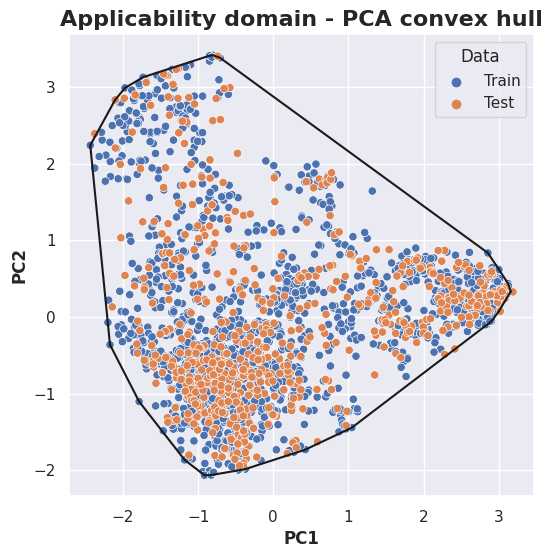

In [5]:
convex = PCA_convexhull(data =process.df_pca, Type = 'Data', ID = 'ID', figsize = (6,6))
convex.convexhull_fit()


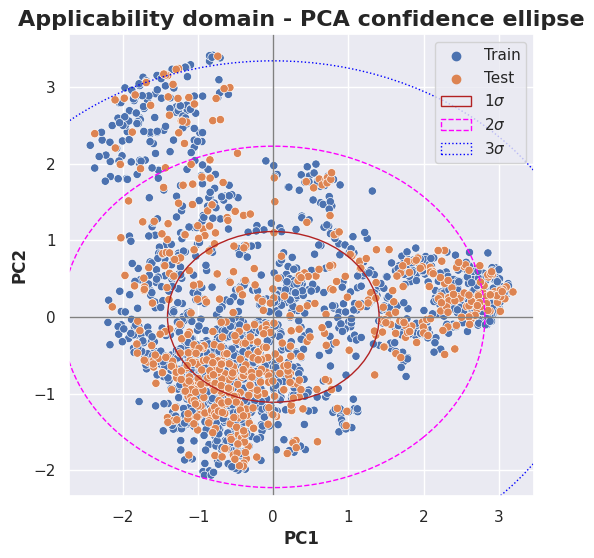

In [7]:
elip = PCA_conf_elip(data =process.df_pca, Type = 'Data', ID = 'ID', figsize =(6,6))
elip.fit()

In [ ]:
## similarity
AllChem.GetMorganFingerprintAsBitVect(mol, maxPath=7, fpSize=2048, nBitsPerHash=2)

In [18]:
AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)

<function rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect>

In [19]:
import warnings
warnings.filterwarnings("ignore")

class similarity_matrix:
    def __init__(self, data_train, data_test, ID, mol_col, function):
        self.data_train = data_train
        self.data_test = data_test
        self.ID = ID
        self.mol_col = mol_col
        self.function = function
    
    def train_process(self):
        self.list_training_name = []
        self.list_training_fp=[]
        for trainnames in self.data_train[self.ID]:
            self.list_training_name.append(trainnames)
        for mol in self.data_train[self.mol_col]:
            fgp= self.function
            self.list_training_fp.append(fgp)
            
    def test_process(self):
        self.list_test_name = []
        self.list_test_fp=[]
        for testnames in self.data_test[self.ID]:
            self.list_test_name.append(testnames)
        for mol in self.data_test[self.mol_col]:
            fgp= self.function 
            self.list_test_fp.append(fgp)
    
    def fit(self):
        self.train_process()
        self.test_process()
        self.list_data_set=self.list_training_name+self.list_test_name #all data set-> training+test+external
        self.list_data_set_fp=self.list_training_fp+self.list_test_fp #all data set-> training+test+external
        
        
        size=len(self.list_data_set_fp)
        self.matrix=pd.DataFrame()
        for m, i in enumerate(self.list_data_set_fp):
            for n, j in enumerate(self.list_data_set_fp):
                similarity=DataStructs.TanimotoSimilarity(i,j)
                self.matrix.loc[self.list_data_set[m],self.list_data_set[n]]=similarity

In [ ]:
simi = similarity_matrix(data_train=df_train, data_test=df_test, 
                         ID = 'Molecule ChEMBL ID', mol_col='ROMol',
                        function =AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048))
simi.fit()

In [ ]:
## COnvexhull

In [ ]:
plt.figure(figsize=(16, 8), dpi=600)
plt.subplot(121)

from sklearn.manifold import Isomap
from matplotlib.pyplot import figure
mds = Isomap(n_components=2, n_jobs= -1)
results = mds.fit(table)
coords = results.embedding_

coords= (coords - np.min(coords)) / (np.max(coords) - np.min(coords))#normalize

coords_training=coords[:len(list_training_fp)]
coords_test=coords[len(list_training_fp):len(list_test_fp)+len(list_training_fp)]
hull = ConvexHull(coords_training)

in_out = []
for p in coords_test:
    point_is_in_hull = point_in_hull(p, hull)
    in_out.append(point_is_in_hull)
    
df_test = pd.DataFrame(coords_test)
df_test['convex'] = in_out




coords_test_in = coords_test[in_out]
coords_test_out = df_test[df_test['convex']==False].drop(['convex'], axis =1).values

plt.scatter(coords_training[:, 0], coords_training[:, 1], marker = 'o',label='Training')#training
# for label, x, y in zip(list_data_set[:len(list_training_fp)], coords_training[:, 0], coords_training[:, 1]): #show molecule name 
#     plt.annotate(label,xy = (x, y), xytext = (0, 0),textcoords = 'offset pixels', ha = 'center', va = 'bottom', fontsize=8) #show molecule name 

'''
Visualize the convex hull
'''
hull = ConvexHull(coords_training)

for simplex in hull.simplices:
    plt.plot(coords_training[simplex, 0], coords_training[simplex, 1], 'k-')



plt.scatter(coords_test_in[:, 0], coords_test_in[:, 1], marker = '^',label='Test_in', color ='g')#test
plt.scatter(coords_test_out[:, 0], coords_test_out[:, 1], marker = 'd',label='Test_out', color = 'r')#test
# for label, x, y in zip(list_data_set[len(list_training_fp):len(list_test_fp)+len(list_training_fp)], coords_test[:, 0], coords_test[:, 1]): #show molecule name 
#     plt.annotate(label,xy = (x, y), xytext = (0, 0),textcoords = 'offset pixels', ha = 'center', va = 'bottom', fontsize=8) #show molecule name 

#plt.scatter(coords_external[:, 0], coords_external[:, 1], marker = 'X', label='External')#external
# for label, x, y in zip(list_data_set[len(list_test_fp)+len(list_training_fp):], coords_external[:, 0], coords_external[:, 1]): #show molecule name 
#     plt.annotate(label,xy = (x, y), xytext = (0, 0),textcoords = 'offset pixels', ha = 'center', va = 'bottom', fontsize=8)#show molecule name 
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",mode="expand", borderaxespad=0, ncol=3,shadow=True, fontsize='12')
plt.xlabel("isomap1",fontweight='bold', fontsize = 16)
plt.ylabel("isomap2",fontweight='bold', fontsize = 16)


plt.subplot(122)


mds = manifold.MDS(n_components=2, dissimilarity="euclidean", random_state=42)
results = mds.fit(table)
coords = results.embedding_

coords= (coords - np.min(coords)) / (np.max(coords) - np.min(coords))#normalize

coords_training=coords[:len(list_training_fp)]
coords_test=coords[len(list_training_fp):len(list_test_fp)+len(list_training_fp)]
hull = ConvexHull(coords_training)


in_out = []
for p in coords_test:
    point_is_in_hull = point_in_hull(p, hull)
    in_out.append(point_is_in_hull)
    
df_test = pd.DataFrame(coords_test)
df_test['convex'] = in_out



coords_test_in = coords_test[in_out]
coords_test_out = df_test[df_test['convex']==False].drop(['convex'], axis =1).values

plt.scatter(coords_training[:, 0], coords_training[:, 1], marker = 'o',label='Training')#training
# for label, x, y in zip(list_data_set[:len(list_training_fp)], coords_training[:, 0], coords_training[:, 1]): #show molecule name 
#     plt.annotate(label,xy = (x, y), xytext = (0, 0),textcoords = 'offset pixels', ha = 'center', va = 'bottom', fontsize=8) #show molecule name 

'''
Visualize the convex hull
'''
hull = ConvexHull(coords_training)

for simplex in hull.simplices:
    plt.plot(coords_training[simplex, 0], coords_training[simplex, 1], 'k-')



plt.scatter(coords_test_in[:, 0], coords_test_in[:, 1], marker = '^',label='Test_in', color ='g')#test
plt.scatter(coords_test_out[:, 0], coords_test_out[:, 1], marker = 'd',label='Test_out', color = 'r')#test
# for label, x, y in zip(list_data_set[len(list_training_fp):len(list_test_fp)+len(list_training_fp)], coords_test[:, 0], coords_test[:, 1]): #show molecule name 
#     plt.annotate(label,xy = (x, y), xytext = (0, 0),textcoords = 'offset pixels', ha = 'center', va = 'bottom', fontsize=8) #show molecule name 

#plt.scatter(coords_external[:, 0], coords_external[:, 1], marker = 'X', label='External')#external
# for label, x, y in zip(list_data_set[len(list_test_fp)+len(list_training_fp):], coords_external[:, 0], coords_external[:, 1]): #show molecule name 
#     plt.annotate(label,xy = (x, y), xytext = (0, 0),textcoords = 'offset pixels', ha = 'center', va = 'bottom', fontsize=8)#show molecule name 
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",mode="expand", borderaxespad=0, ncol=3,shadow=True, fontsize='12')



plt.xlabel("MDS1",fontweight='bold', fontsize = 12)
plt.ylabel("MDS2",fontweight='bold', fontsize = 12)

plt.savefig('all.png', dpi =600)

In [ ]:
process = prepare_dataset(data_train=df_train, data_test=df_test, smile_col ='Canomial_smiles',
                    activity_col='pChEMBL Value',feature_col = None,
                    mol_col = 'ROMol', ID = 'Molecule ChEMBL ID', fp_type='ECFPs')

In [11]:
list_training_name = []
list_training_fp=[]
for trainnames in df_train['Molecule ChEMBL ID']:
    list_training_name.append(trainnames)
for mol in df_train.ROMol:
    fgp= Chem.RDKFingerprint(mol, maxPath=7, fpSize=2048, nBitsPerHash=2)
    list_training_fp.append(fgp)

In [12]:
list_test_name = []
list_test_fp=[]
for testnames in df_test['Molecule ChEMBL ID']:
    list_test_name.append(testnames)
for mol in df_test.ROMol:
    fgp=Chem.RDKFingerprint(mol, maxPath=7, fpSize=4096, nBitsPerHash=2)
    list_test_fp.append(fgp)


In [13]:
'''
import structures
'''
list_data_set=list_training_name+list_test_name #all data set-> training+test+external
list_data_set_fp=list_training_fp+list_test_fp #all data set-> training+test+external

In [14]:
import warnings
warnings.filterwarnings("ignore")
size=len(list_data_set_fp)
table=pd.DataFrame()
for m, i in enumerate(list_data_set_fp):
    for n, j in enumerate(list_data_set_fp):
        similarity=DataStructs.TanimotoSimilarity(i,j)
        table.loc[list_data_set[m],list_data_set[n]]=similarity


KeyboardInterrupt

